In [3]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
import random
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [31]:
list_of_action = {
    0: (0,0),
    1: (0,1),
    2: (0,2),
    3: (1,0),
    4: (1,1),
    5: (1,2),
    6: (2,0),
    7: (2,1),
    8: (2,2)
}

rev_action = {
    (0,0) :0,
    (0,1) :1,
    (0,2) :2,
    (1,0) :3,
    (1,1) :4,
    (1,2) :5,
    (2,0) :6,
    (2,1) :7,
    (2,2) :8
}

In [43]:
def make_state_for_input(obs_env):
    output = np.zeros((3,3,2))
    for i in range(3):
        for j in range(3):
            if obs_env[i,j] == 1:
                #print(list_of_action[i],"1")
                output[i,j,0] = 1
            elif obs_env[i,j] == -1:
                #print(list_of_action[i],"-1")
                output[i,j,1] = 1
    return output


check_state = np.array([[1,0,-1],[0,0,1],[0,-1,0]])
make_state_for_input(check_state).shape, make_state_for_input(check_state)[:,:,0], make_state_for_input(check_state)[:,:,1]

((3, 3, 2),
 array([[1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 0.]]),
 array([[0., 0., 1.],
        [0., 0., 0.],
        [0., 1., 0.]]))

In [138]:
BATCH_SIZE = 64
GAMMA = 0.99
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 40
#EPS_START = 0.9
#EPS_END = 0.05
#EPS_DECAY = 200
TARGET_UPDATE_FREQ = 500



class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        in_features = int(3*3*2)
        
        self.net = nn.Sequential(
            nn.Linear(in_features,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,9)
        )

    def forward(self,x):
        return self.net((x.view(x.size(0), -1)))

    def act(self,obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32)
        q_values = self(obs_t.unsqueeze(0))

        max_q_index = torch.argmax(q_values,dim=1)[0]
        action = max_q_index.detach().item()
        return action


env = TictactoeEnv()

replay_buffer = deque(maxlen=BUFFER_SIZE)
rew_buffer = deque([0.], maxlen=100) #MAYBE 10 is better

episode_reward = 0.


policy_net = Network() #.to("cpu")
target_net = Network() #.to("cpu")
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.Adam(policy_net.parameters(), lr=5e-4)

In [133]:
target_net.parameters

<bound method Module.parameters of Network(
  (net): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=9, bias=True)
  )
)>

In [139]:
def number_wins(eps):    
      N_win = 0
      N_wino = 0
      draw = 0
      for games in range(500):

            env.reset()
            if games%2 == 0:
                  opt_player = OptimalPlayer(epsilon = eps, player = 'O')

            if games%2 == 1:
                  opt_player = OptimalPlayer(epsilon = eps, player = 'X')
                  grid, _, __ = env.observe()
                  comp_move = opt_player.act(grid)
                  env.step(comp_move)
      
            for rounds in range(5):
                  state_now = env.observe()[0]
                  best_action1 = policy_net.act(make_state_for_input(state_now))

                  if state_now[list_of_action[best_action1]] != 0:
                        N_wino = N_wino+1
                        break
        
                  #make the move with that best action
                  env.step(best_action1)
                  #env.render()
                  #Now the computer plays (for a fair game ahaha)
                  grid, _, __ = env.observe()
        
                  if env.observe()[1] == True:
                        if str(env.winner) == 'X' and games%2 == 0:
                              N_win = N_win+1
                        elif str(env.winner) == 'O' and games%2 == 0:
                              N_wino = N_wino+1
                        elif str(env.winner) == 'O' and games%2 == 1:
                              N_win = N_win+1
                        elif str(env.winner) == 'X' and games%2 == 1:
                              N_wino = N_wino+1
                        else:
                              draw = draw+1
                        break
        
                  comp_move = opt_player.act(grid)
                  env.step(comp_move)

                  if env.observe()[1] == True:
                        if str(env.winner) == 'X' and games%2 == 0:
                              N_win = N_win+1
                        elif str(env.winner) == 'O' and games%2 == 0:
                              N_wino = N_wino+1
                        elif str(env.winner) == 'O' and games%2 == 1:
                              N_win = N_win+1
                        elif str(env.winner) == 'X' and games%2 == 1:
                              N_wino = N_wino+1
                        else:
                              draw = draw+1
                        break

      return N_win, N_wino


In [140]:
replay_buffer

deque([])

In [52]:
obs = env.reset()

env.step(1)[0][(1,2)]
list_of_action[3]

(1, 0)

In [141]:
env.reset()

state_zero = env.observe()[0]

for games in range(300):
    env.reset()

    if games%2 == 0:
        player1 = "X"
        player2 = "O"
        opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
    if games%2 == 1:
        player1 = "O"
        player2 = "X"
        #change the state by *-1 when best player is X
        opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
        grid, _, __ = env.observe()
        comp_move = opt_player.act(grid)
        env.step(comp_move)


    for rounds in range(5):

        #I play
        state_now = env.observe()[0]
        #selecting the best action considering the present state
        best_action1 = np.random.randint(0,9)
        
        ###If you can not take the action??
        if state_now[list_of_action[best_action1]] != 0:
            end = True
            rew = -1
            transition = (state_now, best_action1, rew, end, state_zero)
            replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            break

        #make the move with that best action
        env.step(best_action1)

        #Now the computer plays (for a fair game ahaha)
        grid, _, __ = env.observe()
        
        if env.observe()[1] == True:
            rew = env.reward(player=player1)
            transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
            replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            break
        
        
        comp_now = env.observe()[0]
        comp_move = opt_player.act(grid)
        env.step(comp_move)

        if env.observe()[1] == True:
            rew = env.reward(player=player1)
            transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
            replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            break

        #Gather information about the state the game is in after the computer played
        future_state = env.observe()[0]
        
        _, end, winner = env.observe()
        rew = env.reward(player=player1)                    ##HAVE TO CHANGE ACCORDING TO THE PLAYER
        transition = (state_now, best_action1, rew, end, future_state)
        replay_buffer.append(transition)
        episode_reward += rew
        


In [59]:
policy_net.act(make_state_for_input(env.reset()[0]))

2

In [142]:
##############MAIN TRAINING LOOP
#opt_player = OptimalPlayer(epsilon = 0.5, player = 'O')
M_opt = []
M_rand = []
average_reward = []
average_loss = []
current_average_reward = 0
current_training_loss = 0
env.reset()
obs = env.observe()[0]
zero_state = env.observe()[0]
step = 0
epsilon = 0.3
for games in range(20000):
    step += 1
    env.reset()
    epsilon = 0.
    obs = env.observe()[0]
    action = policy_net.act(make_state_for_input(obs))


    if games%2 == 0:
        player1 = "X"
        player2 = "O"
        opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
    if games%2 == 1:
        player1 = "O"
        player2 = "X"
        #change the state by *-1 when best player is X
        opt_player = OptimalPlayer(epsilon = 0.5, player = player2)
        grid, _, __ = env.observe()
        comp_move = opt_player.act(grid)
        env.step(comp_move)

    if games%250 == 0:
        average_reward.append(current_average_reward/250)
        current_average_reward = 0
        print()
        print(current_training_loss/250)
        average_loss.append(current_training_loss/250)
        current_training_loss = 0



    for rounds in range(5):
        step += 1
        #I play
        state_now = env.observe()[0]
        #selecting the best action considering the present state
        if epsilon == 0.:
            best_action1 = policy_net.act(make_state_for_input(state_now))
        else:
            random_number = np.random.randint(0,10)
            if random_number >= epsilon*10:
                best_action1 = policy_net.act(make_state_for_input(state_now))
            else:
                best_action1 = random_number
        #best_action1 = policy_net.act(make_state_for_input(state_now))
        
        ###If you can not take the action??
        if state_now[list_of_action[best_action1]] != 0:
            end = True
            rew = -1
            current_average_reward += -1
            transition = (state_now, best_action1, rew, end, zero_state)
            replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            break

        #make the move with that best action
        env.step(best_action1)

        #Now the computer plays (for a fair game ahaha)
        grid, _, __ = env.observe()
        
        if env.observe()[1] == True:
            rew = env.reward(player=player1)
            current_average_reward += rew
            transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
            replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            break
        
        step += 1
        comp_now = env.observe()[0]
        comp_move = opt_player.act(grid)
        env.step(comp_move)

        if env.observe()[1] == True:
            rew = env.reward(player=player1)
            current_average_reward += rew
            transition = (state_now, best_action1, rew, env.observe()[1], env.observe()[0])
            replay_buffer.append(transition)
            episode_reward += rew
            rew_buffer.append(episode_reward)
            episode_reward = 0.
            break

        #Gather information about the state the game is in after the computer played
        future_state = env.observe()[0]
        
        _, end, winner = env.observe()
        rew = env.reward(player=player1)                    ##HAVE TO CHANGE ACCORDING TO THE PLAYER
        transition = (state_now, best_action1, rew, end, future_state)
        replay_buffer.append(transition)
        episode_reward += rew
        




    ##START GRADIENT STEP
    transitions = random.sample(replay_buffer, BATCH_SIZE)

    obses = np.asarray([make_state_for_input(t[0]) for t in transitions])
    actions = np.asarray([t[1] for t in transitions])
    rew = np.asarray([t[2] for t in transitions])
    dones = np.asarray([t[3] for t in transitions])
    new_obses = np.asarray([make_state_for_input(t[4]) for t in transitions])

    obses_t = torch.as_tensor(obses, dtype=torch.float32)
    actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
    rews_t = torch.as_tensor(rew, dtype=torch.float32).unsqueeze(-1)
    dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
    new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)

    target_q_values = target_net(new_obses_t)
    
    max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
    
    targets = rews_t + GAMMA * (1 - dones_t) * max_target_q_values


    ###COMPUTE LOSS
    q_values = policy_net(obses_t)
    #q_values_max = q_values.max(dim=1, keepdim=True)[0]
    #print(actions_t.shape, q_values.shape)
    action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

    loss = nn.functional.smooth_l1_loss(action_q_values, targets)
    current_training_loss += loss.item()

    ####GRADIENT STEP
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ####UPDATE TARGET NETWORK
    if games % TARGET_UPDATE_FREQ == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if games % 500 == 0:
        print()
        print("game",games)
        print("Avg_rew", np.mean(rew_buffer))
        print("Loss", loss)
        N_me, N_comp = number_wins(0.)
        print("M_opt",N_me,N_comp)
        M_opt.append((N_me-N_comp)/500)
        N_me, N_comp = number_wins(1.)
        print("M_rand",N_me,N_comp)
        M_rand.append((N_me-N_comp)/500)
        



0.0

game 0
Avg_rew -0.93
Loss tensor(0.2044, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 500
M_rand 0 500

0.09190853515267372

0.06497947268188

game 500
Avg_rew -0.67
Loss tensor(0.0611, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 204
M_rand 173 273

0.05868962278962135

0.05979194997251034

game 1000
Avg_rew -0.24
Loss tensor(0.0518, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 99
M_rand 299 146

0.06239051453024149

0.05853687086701393

game 1500
Avg_rew -0.16
Loss tensor(0.0711, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 95
M_rand 339 95

0.059367041751742365

0.05670876668393612

game 2000
Avg_rew 0.16
Loss tensor(0.0511, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 408
M_rand 388 50

0.06636039830744267

0.06339758537709712

game 2500
Avg_rew 0.28
Loss tensor(0.0644, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 400
M_rand 398 39

0.0631248679831624

0.06147429499775171

game 3000
Avg_rew 0.4
Loss tensor(0.0440, grad_fn=<SmoothL1LossBackward0>)
M_opt 0 149
M_rand 407 28

0.06695118527114391

0.062

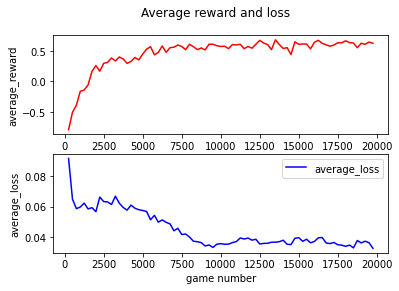

In [145]:
game_number = []
for i in range(80):
    game_number.append(250*i)
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Average reward and loss')
ax1.plot(game_number[1:],average_reward[1:],color='r',label='average_reward')
ax2.plot(game_number[1:],average_loss[1:], color="b",label="average_loss")

ax1.set(xlabel='game_number', ylabel='average_reward')
ax2.set(xlabel='game_number', ylabel='average_loss')

plt.xlabel("game number")
plt.legend()
plt.savefig('Ques11.png')
plt.savefig('Ques11.pdf')
plt.show()

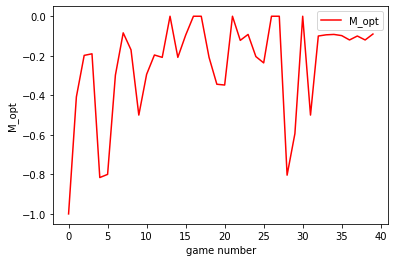

In [146]:

plt.plot(M_opt,color='r',label='M_opt')
plt.ylabel("M_opt")
plt.xlabel("game number")
plt.legend()
plt.show()

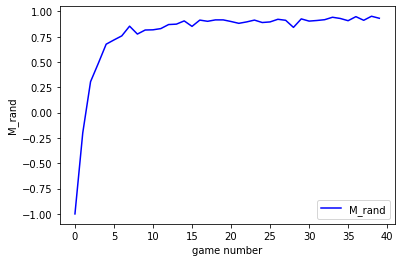

In [147]:
plt.plot(M_rand,color='b',label='M_rand')
plt.ylabel("M_rand")
plt.xlabel("game number")
plt.legend()
plt.show()

In [148]:
number_wins(0.)

(0, 59)

In [149]:
number_wins(1.)

(474, 5)